Con el auge de la IA, hemos llegado a depender más de la toma de decisiones basada en datos para simplificar la vida de los profesionales que trabajan. Ya sea que se trate de logística de la cadena de suministro o de aprobar un préstamo para un cliente, los datos son la clave. En este artículo, exploraremos cómo analizar un conjunto de datos médicos para crear un modelo que prediga qué medicamentos debe tomar un paciente ante un diagnóstico específico. Suena intrigante, ¡así que profundicemos!

In [1]:
# Este entorno de Python 3 viene con muchas bibliotecas útiles de análisis instaladas
# Por ejemplo, aquí tienes varios paquetes útiles para cargar

# Procesamiento de datos
import numpy as np  # álgebra lineal
import pandas as pd  # procesamiento de datos, lectura de archivos CSV (e.g. pd.read_csv)
import collections  # estructuras de datos avanzadas (contadores, diccionarios)

# Visualización de datos
import matplotlib.pyplot as plt  # gráficos y visualizaciones
import seaborn as sns  # gráficos estadísticos
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator  # nubes de palabras y personalización de colores
import graphviz  # visualización de árboles de decisión

# Machine Learning
from sklearn.feature_extraction.text import CountVectorizer  # conversión de texto a datos numéricos
from sklearn.preprocessing import LabelEncoder, label_binarize  # codificación de etiquetas categóricas y binarización de etiquetas
from sklearn.model_selection import train_test_split, cross_val_score  # división de datos en entrenamiento/prueba y validación cruzada
from sklearn.ensemble import RandomForestClassifier  # clasificación con bosques aleatorios
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score  # evaluación modelos (matriz de confusión, ROC, AUC)
from sklearn.tree import export_graphviz # convierte árbol de decisión entrenado (modelo de Random Forest o DecisionTree) para interpretar y visualizar.

# Sistema operativo
import os  # interacción con el sistema operativo (gestión de archivos, directorios)

# Otras utilidades
from IPython.display import Image  # mostrar imágenes en Jupyter Notebook

**Cargue el conjunto de datos y observe las filas superiores**

**Load Data Set and look at the top few rows**

In [2]:
df = pd.read_csv("C:/Users/user/Desktop/Machine-Learning/antibiotics_hospital.csv")
print(df.shape)
df.head()

(831, 10)


,Age,Date of Data Entry,Gender,Diagnosis,Name of Drug,Dosage (gram),Route,Frequency,Duration (days),Indication
0,85,19/12/2019 14:41,Female,"ccf, hypertension, ida, ckd(stage 5), ?icm,",ceftriaxone,1.0,IV,BD,7,icm
1,87,19/12/2019 16:35,Female,"pad(lt u.l), be amputation,/post op, akt",ceftriaxone,1.0,IV,BD,1,post op
2,82,19/12/2019 15:48,Male,"type-2dm, ihd, col, copd, ht",ofloxacin,0.4,IV,BD,3,abd distension with leg swelling
3,82,19/12/2019 15:50,Male,"type-2 dm, ihd, col, copd, ht",cefipime,1.0,IV,BD,5,abd distension with leg swelling
4,82,19/12/2019 15:52,Male,"type-2 dm, ihd, col, copd, ht",azithromycin,0.5,Oral,OD,3,abd distension with leg swelling


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831 entries, 0 to 830
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 831 non-null    int64  
 1   Date of Data Entry  831 non-null    object 
 2   Gender              831 non-null    object 
 3   Diagnosis           831 non-null    object 
 4   Name of Drug        831 non-null    object 
 5   Dosage (gram)       831 non-null    float64
 6   Route               831 non-null    object 
 7   Frequency           831 non-null    object 
 8   Duration (days)     831 non-null    int64  
 9   Indication          830 non-null    object 
dtypes: float64(1), int64(2), object(7)
memory usage: 65.1+ KB


* Cada columna es de tipo string
* Vamos a convertir las columnas Age, Dosage(gram) y Duration(days) a valores numéricos.
* También vamos a convertir la columna Date of Data Entry a formato de fecha y hora.
* Indication tiene un valor nulo, todas las demás columnas no tienen valores nulos.

--------------------------------------------------------------------------------------------------------------------------------------------------------

* Every column is a string column 
* Let's convert column Age, Dosage(gram), Duration(days) to numeric.
* Let's also convert Date of Data Entry into date time.
* Indication has one null value, all other column don't have null values

Vamos a limpiar algunas columnas. En el paso anterior, vimos que todas las columnas son de tipo entero. Así que, para empezar, vamos a convertir Age, Dosage y Duration a valores numéricos. De manera similar, convertiremos la columna Date of Data Entry al tipo datetime. En lugar de convertirlas directamente, crearemos nuevas columnas, es decir, crearemos una columna Age2 que será la versión numérica de la columna Age, y así sucesivamente.

In [4]:
# Conversión de columnas a tipo numérico y de fecha
df['Age2'] = pd.to_numeric(df['Age'],errors='coerce')
df['Dosage (gram)2'] = pd.to_numeric(df['Dosage (gram)'],errors='coerce')
df['Duration (days)2'] = pd.to_numeric(df['Duration (days)'],errors='coerce')
df['Date of Data Entry2'] = pd.to_datetime(df['Date of Data Entry'],errors='coerce')
df.info()
# Convierte las columnas Age, Dosage (gram), Duration (days) y 
# Date of Data Entry a valores numéricos o de fecha, respectivamente. Usa el 
# parámetro errors='coerce' para convertir valores no válidos en NaN.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831 entries, 0 to 830
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Age                  831 non-null    int64         
 1   Date of Data Entry   831 non-null    object        
 2   Gender               831 non-null    object        
 3   Diagnosis            831 non-null    object        
 4   Name of Drug         831 non-null    object        
 5   Dosage (gram)        831 non-null    float64       
 6   Route                831 non-null    object        
 7   Frequency            831 non-null    object        
 8   Duration (days)      831 non-null    int64         
 9   Indication           830 non-null    object        
 10  Age2                 831 non-null    int64         
 11  Dosage (gram)2       831 non-null    float64       
 12  Duration (days)2     831 non-null    int64         
 13  Date of Data Entry2  831 non-null  

C:\Users\user\AppData\Local\Temp\ipykernel_10524\694372585.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date of Data Entry2'] = pd.to_datetime(df['Date of Data Entry'],errors='coerce')


In [5]:
# Filtrar filas con valores nulos
df[(df['Dosage (gram)2'].isnull())
  | (df['Duration (days)2'].isnull())
  | (df['Age2'].isnull())
  | (df['Date of Data Entry2'].isnull())
  ]
# Filtra y muestra las filas donde hay valores nulos en las columnas recién convertidas.

,Age,Date of Data Entry,Gender,Diagnosis,Name of Drug,Dosage (gram),Route,Frequency,Duration (days),Indication,Age2,Dosage (gram)2,Duration (days)2,Date of Data Entry2


**Parece que hay algunos valores basura en el conjunto de datos. Vamos a eliminarlos.**

**Además, sustituiré los valores de las nuevas columnas en las columnas antiguas y eliminaré las columnas recién creadas.**

In [6]:
# Renombrar y eliminar columnas
df = df[~((df['Dosage (gram)2'].isnull())
  | (df['Duration (days)2'].isnull())
  | (df['Age2'].isnull())
  | (df['Date of Data Entry2'].isnull()))
  ]

# Asigna las columnas convertidas a las originales y elimina las columnas auxiliares Age2, Dosage (gram)2, Date of Data Entry2 y Duration (days)2.
df['Age'] = df['Age2'].astype('int')
df['Dosage (gram)'] = df['Dosage (gram)2']
df['Date of Data Entry'] = df['Date of Data Entry2']
df['Duration (days)'] = df['Duration (days)2'].astype('int')
df = df.drop(['Age2','Dosage (gram)2','Date of Data Entry2','Duration (days)2'],axis=1)

print(df.shape)
df.head()

(831, 10)


,Age,Date of Data Entry,Gender,Diagnosis,Name of Drug,Dosage (gram),Route,Frequency,Duration (days),Indication
0,85,2019-12-19 14:41:00,Female,"ccf, hypertension, ida, ckd(stage 5), ?icm,",ceftriaxone,1.0,IV,BD,7,icm
1,87,2019-12-19 16:35:00,Female,"pad(lt u.l), be amputation,/post op, akt",ceftriaxone,1.0,IV,BD,1,post op
2,82,2019-12-19 15:48:00,Male,"type-2dm, ihd, col, copd, ht",ofloxacin,0.4,IV,BD,3,abd distension with leg swelling
3,82,2019-12-19 15:50:00,Male,"type-2 dm, ihd, col, copd, ht",cefipime,1.0,IV,BD,5,abd distension with leg swelling
4,82,2019-12-19 15:52:00,Male,"type-2 dm, ihd, col, copd, ht",azithromycin,0.5,Oral,OD,3,abd distension with leg swelling


# Algunas estadísticas

In [7]:
# #Descripción: Muestra las dimensiones actualizadas del DataFrame, 
# las primeras filas y un resumen estadístico de todas las columnas.
df.describe(include='all')

,Age,Date of Data Entry,Gender,Diagnosis,Name of Drug,Dosage (gram),Route,Frequency,Duration (days),Indication
count,831.000000,831,831,831,831,831.000000,831,831,831.000000,830
unique,NaN,NaN,2,263,55,NaN,3,4,NaN,220
top,NaN,NaN,Male,"ccf, koch's lung, copd, chest infection, pre-d...",ceftriaxone,NaN,IV,BD,NaN,chest infection
freq,NaN,NaN,449,20,221,NaN,534,430,NaN,92
mean,51.194946,2019-12-19 15:17:43.465704192,NaN,NaN,NaN,5.048959,NaN,NaN,3.789410,NaN
min,1.000000,2019-12-19 13:49:00,NaN,NaN,NaN,0.020000,NaN,NaN,1.000000,NaN
25%,38.000000,2019-12-19 14:35:00,NaN,NaN,NaN,0.500000,NaN,NaN,1.000000,NaN
50%,52.000000,2019-12-19 15:13:00,NaN,NaN,NaN,1.000000,NaN,NaN,3.000000,NaN
75%,65.000000,2019-12-19 16:07:00,NaN,NaN,NaN,1.000000,NaN,NaN,5.000000,NaN
max,90.000000,2019-12-19 18:25:00,NaN,NaN,NaN,960.000000,NaN,NaN,28.000000,NaN


Observaciones
* Podemos ver que la edad mínima es 1 y la edad máxima es 90.
* De manera similar, la columna Entrada de datos, contiene datos del 19 de diciembre de 2019 entre la 1 y las 7 p.m (19-Dec-2019 between 1 to 7 pm).
* El género tiene 2 valores únicos.
* La dosis tiene un valor mínimo de 0,02 gramos y un valor máximo de 960 gramos (parece extremo).
* La duración tiene un valor mínimo de 1 y un valor máximo de 28 días.
* Las columnas Diagnóstico, Nombre del medicamento, Ruta, Frecuencia e Indicación tienen valores únicos diferentes. los examinaremos

# Análisis de la columna de ruta (Route) y frecuencia (Frequency)

In [8]:
# Conteo de valores en columnas categóricas
display(df['Route'].value_counts())
print()
df['Frequency'].value_counts()
# Cuenta y muestra la frecuencia de aparición de cada valor en las columnas categóricas Route y Frequency.

Route
IV      534
Oral    293
IM        4
Name: count, dtype: int64

Frequency
BD     430
TDS    283
OD     110
QID      8
Name: count, dtype: int64

Observaciones:
* Hay 3 rutas diferentes de tratamiento farma. La vía de tratamiento farma más utilizada es la intravenosa y la menos utilizada es la intramuscular.
* Hay 4 frecuencias diferentes de tratamiento farmacológico. BD es la frecuencia de tratamiento farmacológico más utilizada y la menos utilizada es QID.

# Analizando la columna "Diagnosis" 

In [9]:
# Se requiere algo de limpieza, haga una nube de palabras para identificar las condiciones médicas más comunes
df['Diagnosis'].value_counts()

Diagnosis
ccf, koch's lung, copd, chest infection, pre-diabetes                               20
general debility e excessive vomitting, uraemic gastritis, hcv aki ckd, retro(+)    18
rvi stage 3, ht disease, renal impairment, koch's lungs, ccf, increased lft         18
severe anaemia,  multiple myeloma,  CKD,  chest infection                           16
neutropenia, fever, anaemia, ca buffalo mucosa, type 2 dm                           15
                                                                                    ..
af,  is he mic hd,  type2 dm,  newly dx rvi                                          1
he, alcoholic hepatitis,  col,  portal ht,  hma,  uti                                1
he,  alcoholic hepatitis,  alcohol col,  portal ht,  hma, uti                        1
acute bronchitis                                                                     1
uti,  operated spinal cord,  hematoma and paraplegia                                 1
Name: count, Length: 263, dtype: 

There are 35359 words in the combination of all diagnosis.


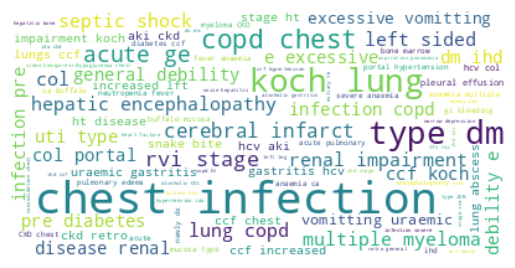

In [10]:
text = " ".join(diagnosis for diagnosis in df.Diagnosis)
print ("There are {} words in the combination of all diagnosis.".format(len(text)))

stopwords = set(STOPWORDS)

# Generar una imagen de nube de palabras
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Mostrar la imagen generada:
# la forma matplotlib:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
#  Crea y muestra una nube de palabras para visualizar los diagnósticos más comunes en la columna Diagnosis.

Observaciones:
* Hay 35359 palabras en la combinación de todos los diagnósticos. Muchos de ellos serán repetitivos.
* Si observamos la nube de palabras, la infección torácica y el pulmón de Koch parecen ser diagnósticos más frecuentes.
*Podemos ver otras condiciones como - diabetes, mieloma, etc.

Veamos las 10 palabras/frases superiores e inferiores. Usaremos la función Contador dentro de la biblioteca de colecciones.

In [11]:
# Contar y mostrar palabras más comunes
A = collections.Counter([i.strip().lower() 
  for i in text.split(',') if (i.strip().lower()) not in stopwords ])
print('Top 10 words/phrases')
display(A.most_common(10))
print('\nBottom 10 words/phrases')
display(A.most_common()[-11:-1])
# Usa collections.Counter para contar las palabras más comunes en el texto y muestra las 10 más frecuentes y las 10 menos frecuentes.

Top 10 words/phrases


[('col', 77),
 ('chest infection', 68),
 ('ihd', 55),
 ('copd', 40),
 ('hypertension', 38),
 ('ccf', 36),
 ('type 2 dm', 32),
 ("koch's lung", 28),
 ('ckd', 28),
 ('uraemic gastritis', 18)]


Bottom 10 words/phrases


[('poorly controlled dm complicated uti', 1),
 ('poorly controlled dm septic shock', 1),
 ('hypertension hepatitis', 1),
 ('uti hepatitis', 1),
 ('uti uti', 1),
 ('cff ppt by chest infection early col', 1),
 ('operated spinal cord', 1),
 ('hematoma and paraplegia he', 1),
 ('rvi with col glandular fever', 1),
 ('fever with confusion ccf', 1)]

Observaciones:

* Entre las 10 palabras/frases principales, vemos que las infecciones de cuello y pecho son más frecuentes. A 77 pacientes se les diagnostica col y a 68 se les diagnostica infección respiratoria.
* Entre las 10 palabras/frases inferiores, vemos que cada una de las enumeradas aparece solo una vez.

# Analizar columna de indicación

In [12]:
# Conteo y proporción acumulada en la columna Indication
display(df['Indication'].value_counts())
print()
df['Indication'].value_counts(1)

Indication
chest infection            92
col                        32
uti                        30
type 2 dm                  25
prevention of infection    22
                           ..
pad(lt u.l)                 1
old stroke                  1
fainting attack             1
cheat infection             1
centepede bite              1
Name: count, Length: 220, dtype: int64

Indication
chest infection            0.110843
col                        0.038554
uti                        0.036145
type 2 dm                  0.030120
prevention of infection    0.026506
                             ...   
pad(lt u.l)                0.001205
old stroke                 0.001205
fainting attack            0.001205
cheat infection            0.001205
centepede bite             0.001205
Name: proportion, Length: 220, dtype: float64

Vemos que hay 220 valores de esta columna de Indicación. Parece que también prevalecen algunos errores de ortografía: cofre versus trampa. Podemos limpiar lo mismo. Para el ejercicio actual, consideremos las indicaciones del 25% superior.

In [13]:
top_indications = df['Indication'].value_counts(1).reset_index()
top_indications['cum_proportion'] = top_indications['proportion'].cumsum()
top_indications = top_indications[top_indications['cum_proportion']<0.25]
top_indications
# Muestra la proporción acumulada de las indicaciones médicas y selecciona el 25% superior basado en la frecuencia.

,Indication,proportion,cum_proportion
0,chest infection,0.110843,0.110843
1,col,0.038554,0.149398
2,uti,0.036145,0.185542
3,type 2 dm,0.030120,0.215663
4,prevention of infection,0.026506,0.242169


In [14]:
# Conteo de nombres únicos de medicamentos
display(df['Name of Drug'].nunique())
print()
display(df['Name of Drug'].value_counts())
# Muestra el número de nombres de medicamentos únicos y la frecuencia de cada uno.

55

Name of Drug
ceftriaxone                    221
co-amoxiclav                   162
metronidazole                   59
cefixime                        58
septrin                         37
clarithromycin                  32
levofloxacin                    31
amoxicillin+flucloxacillin      29
ceftazidime                     24
cefepime                        14
cefipime                        13
clindamycin                     12
rifaximin                       10
amikacin                         9
cefoperazone                     9
coamoxiclav                      9
meropenem                        8
ciprofloxacin                    7
gentamicin                       5
pen v                            5
rifampicin                       5
azithromycin                     5
cifran                           4
mirox                            4
amoxicillin                      4
streptomycin                     4
ceftazidine                      4
clarthromycin                    4
amoxici

Observaciones:

* Hay 55 medicamentos únicos. Nuevamente vemos errores de ortografía: ceftriaxona versus ceftiaxona. 
* Entonces, en realidad, el recuento único de medicamentos puede ser menor.

Consideremos aquí los 5 mejores medicamentos. Crearemos una columna cum_proportion para almacenar la proporción acumulada con la que contribuye cada medicamento.

In [15]:
top_drugs = (df['Name of Drug'].value_counts(1).reset_index())
top_drugs['cum_proportion'] = top_drugs['proportion'].cumsum()
top_drugs = top_drugs.head()
top_drugs

,Name of Drug,proportion,cum_proportion
0,ceftriaxone,0.265945,0.265945
1,co-amoxiclav,0.194946,0.460890
2,metronidazole,0.070999,0.531889
3,cefixime,0.069795,0.601685
4,septrin,0.044525,0.646209


Los 5 medicamentos principales se administran al 64,6% de los pacientes. <br> **PS: Si corregimos los errores ortográficos, esto podría ser más del 64,6%**

In [16]:
df[df['Indication']=='type 2 dm']

,Age,Date of Data Entry,Gender,Diagnosis,Name of Drug,Dosage (gram),Route,Frequency,Duration (days),Indication
751,64,2019-12-19 14:42:00,Female,"acute pulmonary edema, ihd, uti, type 2 dm, ch...",gentamicin,0.80,IV,BD,6,type 2 dm
752,64,2019-12-19 14:42:00,Female,"acute pulmonary edema, ihd, uti, type 2 dm, ch...",ceftriaxone,1.00,IV,BD,5,type 2 dm
753,78,2019-12-19 14:23:00,Female,"anteroseptal mi, klebsiella pneumonia, hyperte...",co-amoxiclav,1.20,IV,TDS,8,type 2 dm
754,54,2019-12-19 14:45:00,Female,"hydropneumothorax, empyema, type 2 dm, myoma u...",metronidazole,0.75,IV,TDS,1,type 2 dm
755,54,2019-12-19 14:47:00,Female,"hydropneumothorax, empyema, type 2 dm, myoma u...",co-amoxiclav,1.20,IV,TDS,14,type 2 dm
756,78,2019-12-19 15:21:00,Female,"type 2 dm, hypoglycaemia, ihr",cefixime,0.20,Oral,BD,5,type 2 dm
757,70,2019-12-19 14:04:00,Female,"neutropenia, fever, anaemia, ca buffalo mucosa...",ceftriaxone,1.00,IV,BD,2,type 2 dm
758,70,2019-12-19 14:05:00,Female,"neutropenia, fever, anaemia, ca buffalo mucosa...",amikacin,0.50,IV,BD,8,type 2 dm
759,70,2019-12-19 14:06:00,Female,"neutropenia, fever, anaemia, ca buffalo mucosa...",ceftazidime,2.00,IV,TDS,2,type 2 dm
760,56,2019-12-19 14:44:00,Male,"uti, type 2 dm, ihd, hbs ag(+)",ceftriaxone,1.00,IV,BD,1,type 2 dm


In [17]:
'''
Aquí, consideraremos los marcos de datos top_indications y top_drugs. 
Creamos y tratamos de ver la distribución entre ellos. 
es decir, comparamos el nombre de los 5 medicamentos principales con el 25 % de las indicaciones principales. 
Usaremos la función pivot_table().
'''
# top 5 drug name vs top 25% Indication
# df.pivot_table(index='Name of Drug',columns='Indication',values='Age',aggfunc='count')
(df[(df['Indication'].isin(top_indications['Indication']))
   &(df['Name of Drug'].isin(top_drugs['Name of Drug']))]
.pivot_table(index='Indication',columns='Name of Drug',values='Age',aggfunc='count')
)

Name of Drug,cefixime,ceftriaxone,co-amoxiclav,metronidazole,septrin
Indication,,,,,
chest infection,7.0,22.0,27.0,3.0,1.0
col,1.0,14.0,3.0,3.0,1.0
prevention of infection,2.0,6.0,3.0,2.0,1.0
type 2 dm,2.0,7.0,4.0,1.0,NaN
uti,3.0,9.0,2.0,NaN,NaN


Observations:
* for **chest infection**, co-amoxiclav is the most recommended medicine followed by ceftriaxone.
* Similar observations can be drawn for other indications.

**Important thing to note is that these medicines are prescribed under several other factors - like the Age, Gender, Diagnosis and Medical history of the patient.**

In [18]:
'''
Aquí intentaremos comprender si existen algunas afecciones que aparecen en pacientes mayores. 
Consideraremos las top_indications y examinaremos los valores medios y medianos de edad.
'''
(df[(df['Indication']=='type 2 dm') &(df['Name of Drug'].isin(top_drugs['Name of Drug'])) ]
.sort_values(by='Name of Drug'))

,Age,Date of Data Entry,Gender,Diagnosis,Name of Drug,Dosage (gram),Route,Frequency,Duration (days),Indication
756,78,2019-12-19 15:21:00,Female,"type 2 dm, hypoglycaemia, ihr",cefixime,0.20,Oral,BD,5,type 2 dm
765,49,2019-12-19 14:40:00,Female,"bppv, type2 DM, postural hypertension",cefixime,1.00,Oral,BD,5,type 2 dm
752,64,2019-12-19 14:42:00,Female,"acute pulmonary edema, ihd, uti, type 2 dm, ch...",ceftriaxone,1.00,IV,BD,5,type 2 dm
757,70,2019-12-19 14:04:00,Female,"neutropenia, fever, anaemia, ca buffalo mucosa...",ceftriaxone,1.00,IV,BD,2,type 2 dm
760,56,2019-12-19 14:44:00,Male,"uti, type 2 dm, ihd, hbs ag(+)",ceftriaxone,1.00,IV,BD,1,type 2 dm
764,49,2019-12-19 14:39:00,Female,"bppv, type2 DM, postural hypertension",ceftriaxone,1.00,IV,BD,1,type 2 dm
770,53,2019-12-19 16:10:00,Female,"dm, acute ge, koch's lung",ceftriaxone,1.00,IV,BD,3,type 2 dm
772,67,2019-12-19 14:39:00,Female,"uti , mi, dm, ckd, cuf, cff ppt by chest in...",ceftriaxone,1.00,IV,BD,7,type 2 dm
773,38,2019-12-19 14:50:00,Male,"right sided hemiplegia, uncontrolled dm, chron...",ceftriaxone,1.00,IV,BD,2,type 2 dm
753,78,2019-12-19 14:23:00,Female,"anteroseptal mi, klebsiella pneumonia, hyperte...",co-amoxiclav,1.20,IV,TDS,8,type 2 dm


In [19]:
(df[df['Indication'].isin(top_indications['Indication'])].groupby('Indication')['Age']
.agg(['mean','median','count'])
)

,mean,median,count
Indication,,,
chest infection,57.173913,61.5,92
col,48.031250,48.0,32
prevention of infection,42.136364,46.0,22
type 2 dm,63.560000,62.0,25
uti,50.233333,53.5,30


Observaciones:

* Indicaciones: la col y la prevención de infecciones se observan más en pacientes más jóvenes.
* uti se observa en pacientes de mediana edad.
* Indicaciones: la infección torácica y la DM tipo 2 se observan más en pacientes de edad avanzada.

//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

Observations:
* Indications - col and prevention of infection is more observed in younger patients
* uti is observed in mid-age patients
* Indications - chest infection and type 2 dm is more observed in older patients

In [20]:
# Agrupa los datos por indicación y medicamento para analizar la media, mediana y cantidad de pacientes por edad.
(df[df['Name of Drug'].isin(top_drugs['Name of Drug'])].groupby('Name of Drug')['Age']
.agg(['mean','median','count']).sort_values(by='median')
)

,mean,median,count
Name of Drug,,,
septrin,44.513514,40.0,37
cefixime,43.137931,42.0,58
ceftriaxone,50.484163,49.0,221
metronidazole,53.661017,54.0,59
co-amoxiclav,56.518519,60.0,162


Observaciones:
1. Se prescribe septrina (septrin) y cefixima (cefixime) a pacientes más jóvenes.
2. ceftriaxona (ceftriaxone) se prescribe a pacientes de mediana edad
3. Se prescribe metronidazol (metronidazole) y co-amoxiclav a pacientes mayores.

**Modelling Approach:**

Here, we will try to help the Pharmacist or the Prescribing Doctor. The problem statement is to identify which Drug will be given to the patient basis the Diagnosis, Age and Gender column.

Few considerations and assumptions:

1. For this exercise - we will consider only the top 5 drugs and mark the rest as Others.
2. So, for each value of (Diagnosis, Age, Gender) - the objective is to identify the drug that will be recommended. The baseline model is (1/6) = 16.67% accuracy.

**Let us see if we can try to beat that. We will create a copy of the dataframe for the modelling exercise.**

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

**Enfoque de modelado:**

Aquí intentaremos ayudar al Farmacéutico o al Médico Prescriptor. El planteamiento del problema es identificar qué medicamento se le administrará al paciente según la columna Diagnóstico, Edad y Sexo.

Pocas consideraciones y suposiciones:

1. Para este ejercicio, consideraremos solo los 5 medicamentos principales y marcaremos el resto como Otros.
2. Entonces, para cada valor de (Diagnóstico, Edad, Género), el objetivo es identificar el medicamento que se recomendará. El modelo de referencia es (1/6) = 16,67% de precisión.

**Veamos si podemos intentar superar eso. Crearemos una copia del marco de datos para el ejercicio de modelado.**

In [21]:
adf = df.copy()
adf['Output'] = np.where(df['Name of Drug'].isin(top_drugs['Name of Drug']),df['Name of Drug'],'Other')
adf['Output'].value_counts()

Output
Other            294
ceftriaxone      221
co-amoxiclav     162
metronidazole     59
cefixime          58
septrin           37
Name: count, dtype: int64

También hemos visto esta distribución anteriormente. Significa que las clases no están distribuidas uniformemente. Tendremos que tener esto en cuenta al inicializar el modelo.

In [22]:
# The below value corresponds to the unique vocabulary
len(set([i.strip().lower() for i in text.split(',') if (i.strip().lower()) not in stopwords ]))

572

Intentaremos capturar palabras/ngramas más frecuentes en la columna de diagnóstico. Usaremos el módulo Count Vectorizer.

In [23]:
# Intentaremos capturar más frecuentes words/ngrams usando Count Vectorizer
vectorizer = CountVectorizer(max_features=150,stop_words='english',ngram_range=(1,3))
X = vectorizer.fit_transform(adf['Diagnosis'].str.lower())
vectorizer.get_feature_names_out()

array(['abscess', 'acute', 'acute ge', 'af', 'aki', 'aki ckd',
       'aki ckd retro', 'alcoholic', 'anaemia', 'art', 'bite', 'bleeding',
       'bone', 'ca', 'cap', 'ccf', 'ccf chest', 'ccf chest infection',
       'ccf increased', 'ccf increased lft', 'ccf koch', 'ccf koch lung',
       'cerebral', 'cerebral infarct', 'chest', 'chest infection',
       'chest infection pre', 'chronic', 'ckd', 'ckd chest infection',
       'ckd retro', 'col', 'col portal', 'col portal hypertension',
       'copd', 'copd chest', 'copd chest infection', 'debility',
       'debility excessive', 'debility excessive vomitting', 'diabetes',
       'disease', 'disease renal', 'disease renal impairment', 'dm',
       'dm ihd', 'edema', 'effusion', 'encephalopathy', 'excessive',
       'excessive vomitting', 'excessive vomitting uraemic', 'failure',
       'fever', 'gastritis', 'gastritis hcv', 'gastritis hcv aki', 'ge',
       'general', 'general debility', 'general debility excessive',
       'gi bleeding', 

Aquí, crearemos un marco de datos único que contiene las características que acabamos de crear junto con la columna de edad y sexo como entrada. Usaremos Label Encoder para convertir los nombres de los medicamentos en valores numéricos.

In [24]:
# Creacion del Dataset

feature_df = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())
feature_df['Age'] = adf['Age'].fillna(0).astype('int')
feature_df['Gender_Male'] = np.where(adf['Gender']=='Male',1,0)

le = LabelEncoder()
# feature_df['Output'] = adf['Output']
feature_df['Output'] = le.fit_transform(adf['Output'])

print(feature_df.shape)
feature_df.head(2)

(831, 153)


,abscess,acute,acute ge,af,aki,aki ckd,aki ckd retro,alcoholic,anaemia,art,...,uraemic gastritis hcv,uti,uti type,uti type dm,vomitting,vomitting uraemic,vomitting uraemic gastritis,Age,Gender_Male,Output
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,85,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,87,0,2


In [25]:
mapping_df = pd.DataFrame()
mapping_df['Output'] = feature_df['Output']
mapping_df['Actual_Name'] = le.inverse_transform(feature_df['Output'])
mapping_df = mapping_df.sort_values(by='Output').drop_duplicates()
mapping_df

,Output,Actual_Name
415,0,Other
635,1,cefixime
801,2,ceftriaxone
222,3,co-amoxiclav
519,4,metronidazole
658,5,septrin


Ahora haremos una prueba de tren dividida. Mantendremos el 20% de los datos como conjunto de prueba. Usaremos el argumento random_state para garantizar la reproducibilidad.

In [26]:
# Clasificación de medicamentos usando Random Forest
X_train, X_test, y_train, y_test = train_test_split(feature_df.drop('Output',axis=1).fillna(-1), 
                                                    feature_df['Output'], 
                                                    test_size=0.2, random_state=42)



Aquí, he intentado usar el modelo de Random Forest. Puedes probar con otros modelos también. Utilizaremos el argumento random_state para garantizar la reproducibilidad. Usaremos el parámetro class_weight, ya que habíamos visto anteriormente que las clases no están distribuidas de manera uniforme.

In [27]:
# Divide los datos en conjuntos de entrenamiento y prueba, luego entrena un modelo 
# Random Forest para clasificar los medicamentos según las características del paciente.
clf = RandomForestClassifier(max_depth=6, random_state=0, class_weight='balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6, random_state=0)

In [28]:
# accuracy en X_train data
final_accuracy = clf.score(X_train, y_train)
print("final_accuracy is : ",final_accuracy)

# Crear una matriz de confusión para determinar y visualizar la puntuación de precisión
clf_predict = clf.predict(X_train)
# cmat = confusion_matrix(y_train, clf_predict)
# print("confusion matrix is : \n",cmat)

print(classification_report(y_train, clf_predict,
                            target_names=list(mapping_df['Actual_Name'])))

final_accuracy is :  0.44126506024096385
               precision    recall  f1-score   support

        Other       0.73      0.35      0.48       236
     cefixime       0.19      0.86      0.31        49
  ceftriaxone       0.69      0.27      0.39       176
 co-amoxiclav       0.50      0.50      0.50       127
metronidazole       0.42      0.65      0.51        49
      septrin       0.41      0.93      0.57        27

     accuracy                           0.44       664
    macro avg       0.49      0.59      0.46       664
 weighted avg       0.60      0.44      0.45       664



In [29]:
# accuracy on X_test data
final_accuracy = clf.score(X_test, y_test)
print("final_accuracy is : ",final_accuracy)

# creating a confusion matrix for determining and visualizing the accuracy score
clf_predict = clf.predict(X_test)

print(classification_report(y_test, clf_predict,
                            target_names=list(mapping_df['Actual_Name'])))
# cmat = confusion_matrix(y_test, clf_predict, labels=clf.classes_)
# print("confusion matrix is : \n",cmat)

final_accuracy is :  0.40119760479041916
               precision    recall  f1-score   support

        Other       0.69      0.41      0.52        58
     cefixime       0.09      0.56      0.15         9
  ceftriaxone       0.50      0.13      0.21        45
 co-amoxiclav       0.62      0.66      0.64        35
metronidazole       0.29      0.40      0.33        10
      septrin       0.38      0.50      0.43        10

     accuracy                           0.40       167
    macro avg       0.43      0.44      0.38       167
 weighted avg       0.55      0.40      0.42       167



In [30]:
# Extraer un solo árbol del modelo Random Forest (el árbol número 0)
tree = clf.estimators_[0]

print(len(feature_df.columns))  # Verifica el número de columnas en tu conjunto de características
print(len(tree.feature_importances_))  # Verifica cuántas características usa el árbol

153
152


In [31]:
# Obtener la diferencia entre el número de columnas
extra_columns = len(feature_df.columns) - len(tree.feature_importances_)

# Verificar si hay columnas de más
if extra_columns > 0:
    # Eliminar las columnas adicionales
    feature_df = feature_df.iloc[:, :-extra_columns]

# Ahora puedes volver a generar el gráfico
dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=feature_df.columns,  
                           class_names=list(mapping_df['Actual_Name']),
                           filled=True, rounded=True,  
                           special_characters=True)  

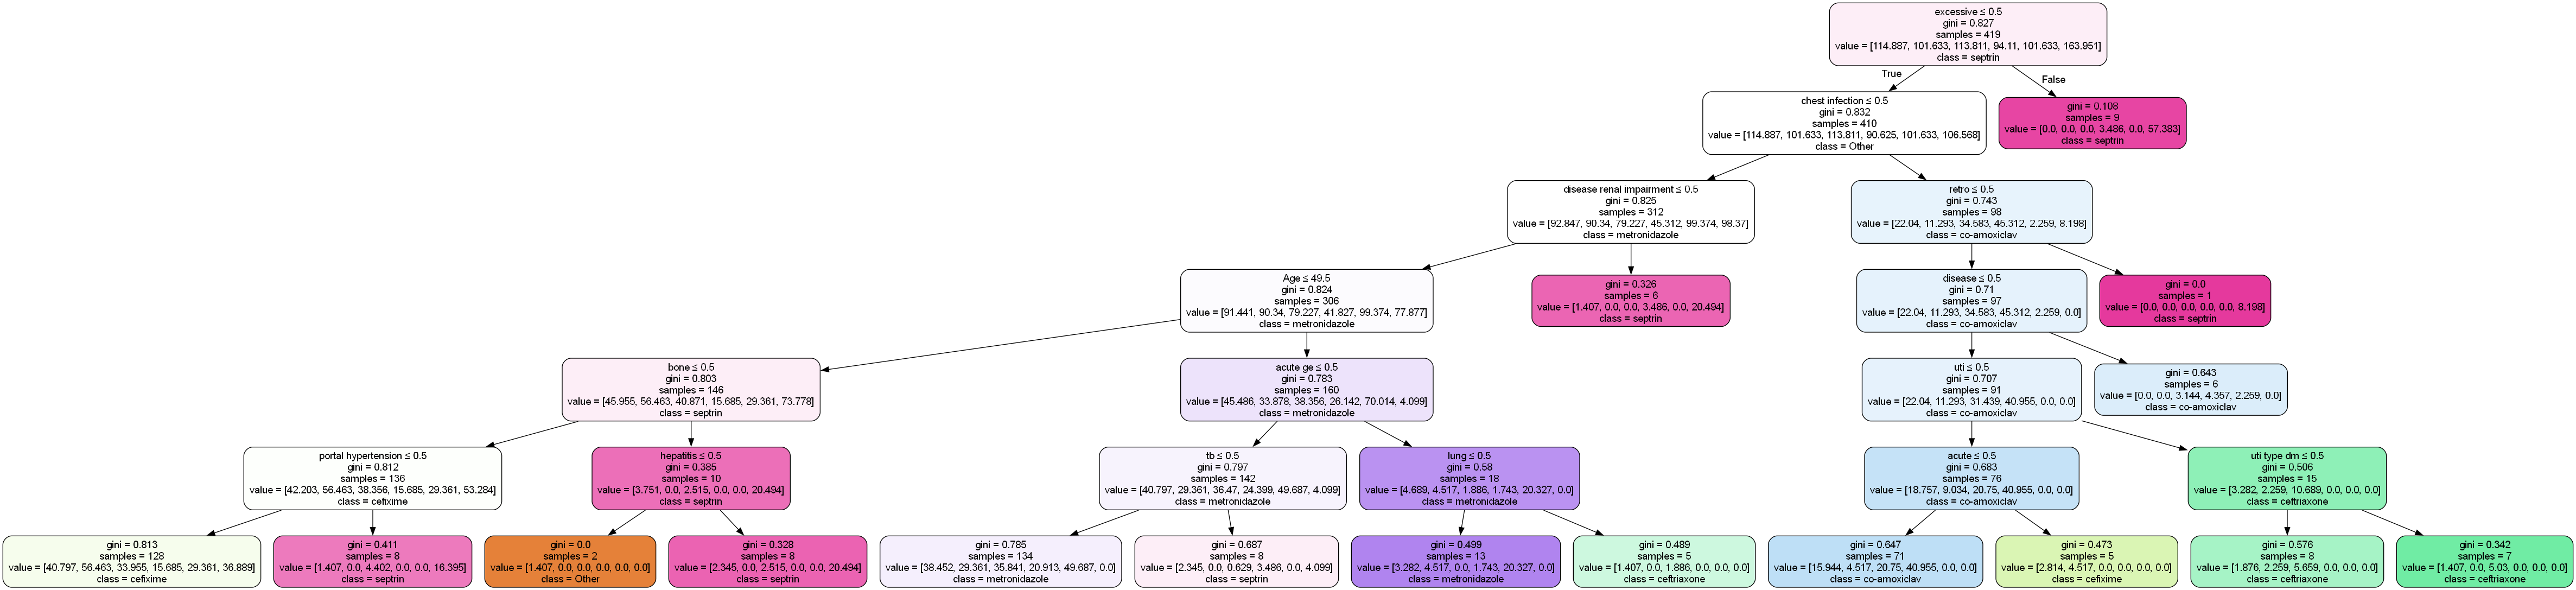

In [32]:
# Generar el gráfico de árbol de decisión
dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=feature_df.columns,  
                           class_names=list(mapping_df['Actual_Name']),
                           filled=True, rounded=True,  
                           special_characters=True)

# Crear el gráfico
graph = graphviz.Source(dot_data)

# Guardar en un archivo PDF
graph.render("decision_tree")

# Visualizar en el notebook como imagen PNG
graph_data = graph.pipe(format='png')  # Renderiza como PNG
Image(graph_data)

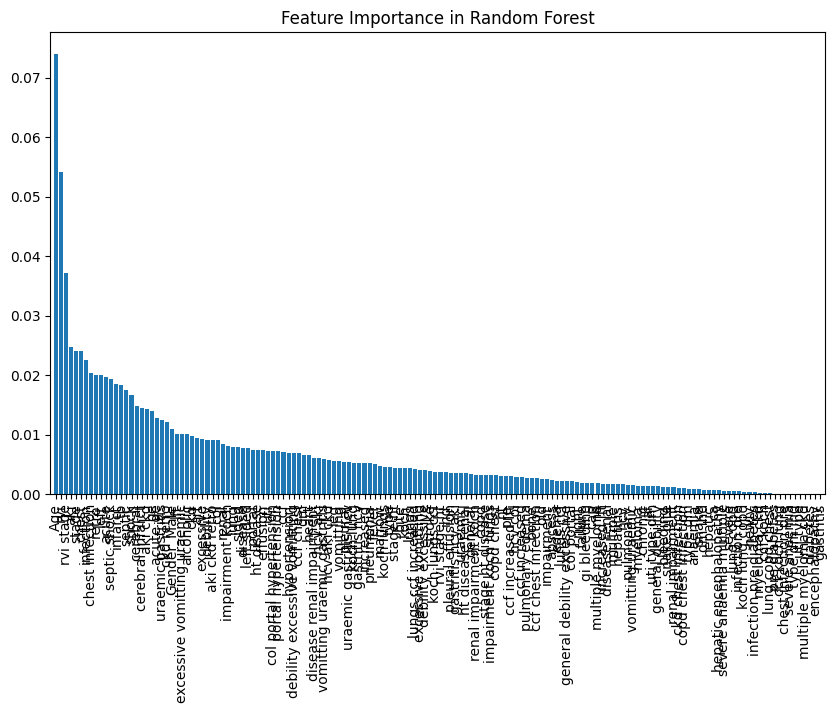

In [33]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance in Random Forest")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_df.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

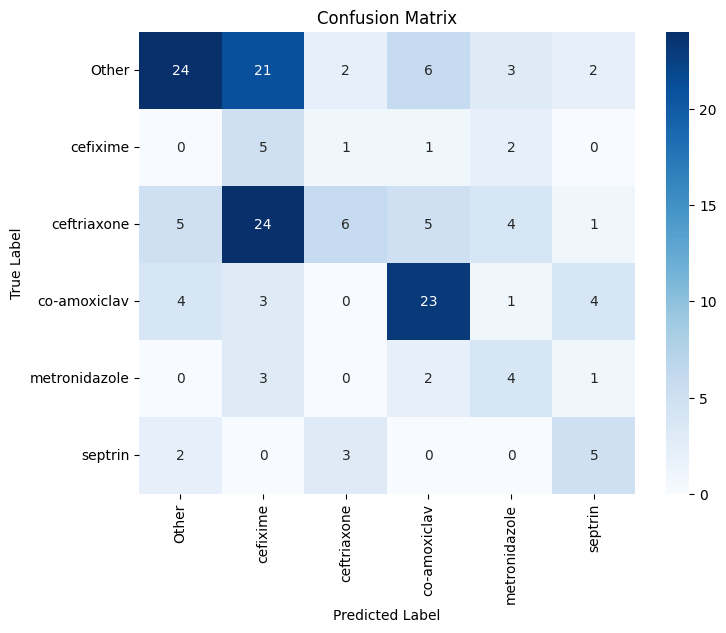

In [34]:
# Predicciones
clf_predict = clf.predict(X_test)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, clf_predict)

# Visualización
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(mapping_df['Actual_Name']), yticklabels=list(mapping_df['Actual_Name']))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

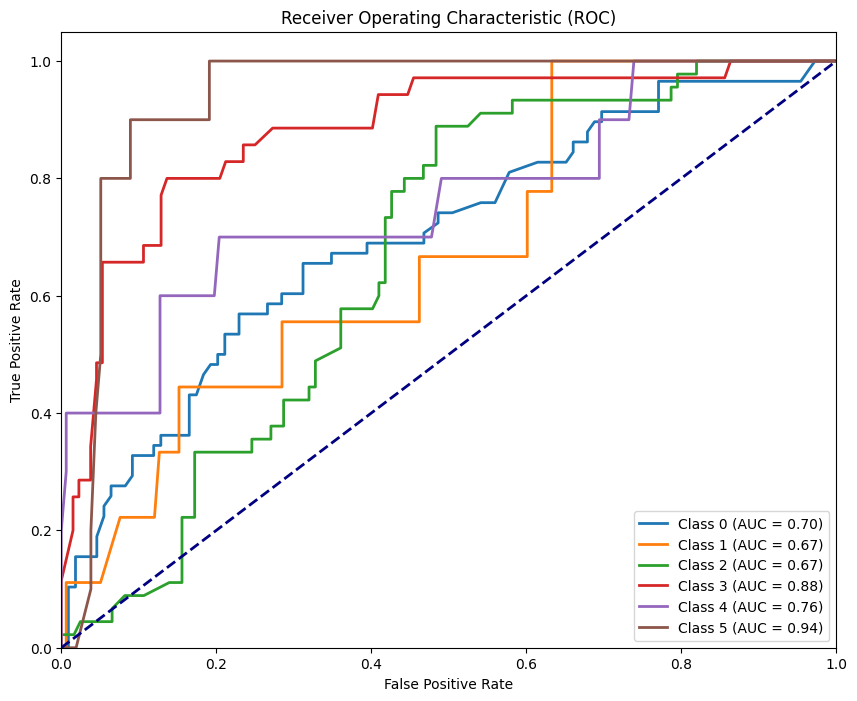

In [35]:
# Binarizar las etiquetas si son multiclasificación
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Obtener las predicciones de probabilidades
y_score = clf.predict_proba(X_test)

# Crear gráficos ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

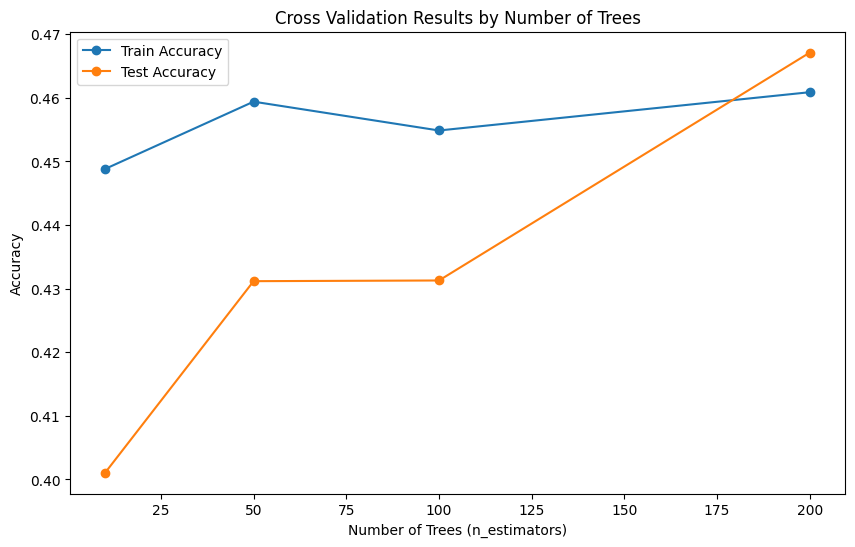

In [36]:
# Crear listas para almacenar los resultados
train_results = []
test_results = []
n_estimators_range = [10, 50, 100, 200]

for n in n_estimators_range:
    clf = RandomForestClassifier(n_estimators=n, random_state=42)
    clf.fit(X_train, y_train)

    # Evaluar en conjunto de entrenamiento
    train_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy').mean()
    train_results.append(train_score)

    # Evaluar en conjunto de prueba
    test_score = cross_val_score(clf, X_test, y_test, cv=3, scoring='accuracy').mean()
    test_results.append(test_score)

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_results, label='Train Accuracy', marker='o')
plt.plot(n_estimators_range, test_results, label='Test Accuracy', marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Cross Validation Results by Number of Trees')
plt.show()

**Observaciones Clave:**

* El modelo tiene una precisión del 41.11% en los datos de entrenamiento y del 38.32% en los datos de prueba.
* Si observamos la puntuación f1, vemos que para otros nombres de medicamentos, el conjunto de entrenamiento tenía un valor de 0.44 y el conjunto de prueba un valor de 0.49.
* También podemos notar que la puntuación f1 en el conjunto de prueba es más baja para "cefixima" y "ceftriaxona". Mientras que "cefixima" tiene solo 9 muestras, "ceftriaxona" tiene 45 muestras. Por lo tanto, debemos analizar estos puntos de datos para comprender cómo mejorar nuestros conjuntos de características.

**Conclusión y puntos clave:**

* En este análisis, trabajamos con un conjunto de datos médicos de principio a fin.
Primero, limpiamos los datos. Luego observamos algunas estadísticas básicas, distribuciones e incluso creamos una nube de palabras para entender mejor las columnas.
* Después formulamos un problema con el objetivo de ayudar al farmacéutico o al médico que prescribe. El objetivo era identificar qué medicamento se recetaría al paciente en función de las columnas de diagnóstico, edad y género.
* Para el ejercicio de modelado, consideramos las 150 palabras, bigramas o trigramas más comunes de la columna de diagnóstico. Es decir, desglosamos la columna de diagnóstico y creamos 150 características a partir de ella.
También teníamos las características de edad y género. En total, utilizamos 152 características.
* Con estas 152 características, intentamos determinar qué medicamento sería recetado.
* El modelo inicial o aleatorio tenía una precisión del 16.67%. Nuestro modelo alcanzó una precisión del 41.11% en los datos de entrenamiento y del 38.32% en los datos de prueba, lo cual representa una mejora significativa en comparación con el modelo base.

**Algunas cosas para intentar mejorar el rendimiento del modelo:**

* Probar con TF-IDF o embeddings para extraer características.
* Probar diferentes modelos y usar búsqueda en cuadrícula (grid search) y validación cruzada para optimizar la precisión.
* Intentar predecir más medicamentos.
* Aprovechar el poder de la ciencia de datos en el campo médico puede generar resultados innovadores. Al analizar grandes cantidades de datos médicos, los científicos de datos pueden descubrir patrones que conduzcan a tratamientos y avances. Con el potencial de revolucionar la industria de la salud, integrar la ciencia de datos en el ámbito médico no solo es una buena idea, es una necesidad.

-------------------------------------------------------------------------------------------------------------------------------------------------------

**Key Observations:**

* The model is 41.11% accurate on train data and 38.32% accurate on the test data. 
* If we look at f1-score,  we see that for Other drug names - train dataset had value of 0.44 and test dataset had value of 0.49
* We can also see that test f1-score is lower for cefixime and ceftriaxone. While cefixime has only 9 samples, ceftriaxone has 45 samples. So, we need to analyze these datapoints to understand the scope of improving out feature sets.

**Conclusion and Key takeaways:**

* In this article, we analyzed a medical dataset end to end. 
* Then we cleaned the dataset. We saw some basic statistics, distribution and even a wordcloud to understand the columns.
* Then we created a problem statement to help the Pharmacist or the Prescribing Doctor. It was to identify which Drug will be given to the patient basis the Diagnosis, Age and Gender column. 
* For the modelling exercise, we considered top 150 words/bigrams/trigrams from the Diagnosis column. Let's say we dissected the diagnosis column and created 150 features out of it.
* We had the Age and Gender feature as well. So, in total we had 152 features.
* Using these 152 features, we tried to determine which medicine/drug will be prescribed.
* The baseline/random model was 16.67% accurate. Our model was 41.11% accurate on train data and 38.32% accurate on the test data. That is a significant improvement over baseline model.

**Some things to try out to improve the model performance:**

* Try TF-IFD or embeddings to extract features.
* Try different models and use grid search and cross validation to optimize accuracy.
* Try predicting more medicines.

Leveraging the power of data science in the medical field can yield groundbreaking results. By analyzing vast amounts of medical data, data scientists can uncover patterns that can lead to discoveries and treatments. With the potential to revolutionize the healthcare industry, integrating data science into the medical domain is not just a good idea, it's a necessity.